<a href="https://colab.research.google.com/github/Sohana-Pardeep112/Data_Analytics_on_sales_data/blob/main/Task_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas openpyxl

In [2]:
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt

In [33]:
vehicle_data = pd.read_csv('/content/vehicle_data_monthly.csv')

vehicle_data['YearMonth'] = vehicle_data['YEAR'].astype(str) + '-' + vehicle_data['MONTH'].astype(str).str.zfill(2)
vehicle_data['Date'] = pd.to_datetime(vehicle_data['YearMonth'] )
print(vehicle_data[['YEAR', 'MONTH', 'Date']].head(10))

   YEAR  MONTH       Date
0  2097     12 2097-12-01
1  2062      1 2062-01-01
2  2062      3 2062-03-01
3  2049      4 2049-04-01
4  2042      7 2042-07-01
5  2042      4 2042-04-01
6  2042      7 2042-07-01
7  2042      4 2042-04-01
8  2042      8 2042-08-01
9  2025      6 2025-06-01


In [18]:
vehicle_data[['Fuelcost', 'Trips' , 'FuelBurned']] = vehicle_data[['Fuelcost', 'Trips' , 'FuelBurned']].fillna(0)
print(vehicle_data[['Trips', 'FuelBurned', 'Fuelcost']].isnull().sum())


Trips         0
FuelBurned    0
Fuelcost      0
dtype: int64


In [29]:
vehicle_data['Trips'] = pd.to_numeric(vehicle_data['Trips'], errors='coerce')
vehicle_data['FuelBurned'] = pd.to_numeric(vehicle_data['FuelBurned'], errors='coerce')
vehicle_data['Fuelcost'] = pd.to_numeric(vehicle_data['Fuelcost'], errors='coerce')

In [85]:
vehicle_data = vehicle_data[(vehicle_data['YEAR'] >= 2000) & (vehicle_data['YEAR'] <= 2025)]
print(vehicle_data.dtypes)

MS_ID                           int64
VehicleId                       int64
VehicleRegistration            object
MONTH                           int64
MaxSpeed                        int64
AvgSpeed                        int64
MaxSpeedTime                   object
Ignitioncount                   int64
Distance                      float64
FuelBurned                    float64
Fuelcost                      float64
RunningTime                     int64
IdleTime                        int64
StopTime                        int64
YEAR                            int64
AvgBatteryVolt                float64
AvgBatteryHealth               object
Trips                         float64
YearMonth                      object
Date                   datetime64[ns]
Active                           bool
FuelEfficiency                float64
dtype: object


In [84]:
monthly_summary = vehicle_data.groupby('Date')[['Distance', 'FuelBurned', 'RunningTime']].sum().reset_index()
print(monthly_summary.head(10))

        Date      Distance     FuelBurned  RunningTime
0 2025-06-01  1.595703e+06  150720.259219    122859724


In [46]:
summary = vehicle_data.groupby('VehicleId')[['Fuelcost', 'Distance']].sum()
summary['avg_fuel_cost'] = summary['Fuelcost'] / summary['Distance']

summary = summary.reset_index()
print(summary[['VehicleId', 'avg_fuel_cost']].head(10))

   VehicleId  avg_fuel_cost
0     266734      25.263000
1     266735      16.842000
2     266736      21.052500
3     266738      18.045000
4     266741      19.433077
5     267673      21.052500
6     268860      64.160000
7     268862      64.160000
8     268863            NaN
9     268864      42.773333


In [48]:
summary_idle = vehicle_data.groupby('VehicleId')['IdleTime'].mean().reset_index(name='avg_idle_time')
print(summary_idle.head(10))


   VehicleId  avg_idle_time
0     266734         1460.0
1     266735        45456.0
2     266736         3319.0
3     266738         1153.0
4     266741         8333.0
5     267673         9907.0
6     268860        25629.0
7     268862        97157.0
8     268863            0.0
9     268864        24144.0


In [50]:
#Vehicle-Level KPIs:
recent = vehicle_data[vehicle_data['Date'] >= vehicle_data['Date'].max() - pd.DateOffset(months=6)]
distance_sum = recent.groupby('VehicleId')['Distance'].sum()
most = distance_sum.idxmax()
least = distance_sum.idxmin()
print(f"Most: Vehicle {most} - {distance_sum[most]:.2f} km")
print(f"Least: Vehicle {least} - {distance_sum[least]:.2f} km")


Most: Vehicle 269917 - 26417.04 km
Least: Vehicle 268863 - 0.00 km


In [51]:
time_ratio = vehicle_data.groupby('VehicleId')[['IdleTime', 'RunningTime']].sum().reset_index()
time_ratio = time_ratio[time_ratio['RunningTime'] > 0]
time_ratio['IdleToRunningRatio'] = time_ratio['IdleTime'] / time_ratio['RunningTime']
high_idle_ratio = time_ratio.sort_values(by='IdleToRunningRatio', ascending=False)
print(high_idle_ratio[['VehicleId', 'IdleToRunningRatio']].head(10))


     VehicleId  IdleToRunningRatio
825     270957         2632.197183
48      268945          122.509278
837     270976           59.993192
330     269919           59.714286
139     269372           40.081356
349     269954           34.500000
272     269811           30.666667
122     269098           27.175073
488     270255           15.741935
756     270818           14.803959


In [52]:
efficiency = vehicle_data.groupby('VehicleId')[['Distance', 'FuelBurned']].sum().reset_index()
efficiency = efficiency[efficiency['FuelBurned'] > 0]
efficiency['FuelEfficiency'] = efficiency['Distance'] / efficiency['FuelBurned']
top5_efficiency = efficiency.sort_values(by='FuelEfficiency', ascending=False).head(5)
print(top5_efficiency[['VehicleId', 'FuelEfficiency']])


     VehicleId  FuelEfficiency
754     270811            50.0
123     269099            33.0
167     269413            22.0
65      268981            22.0
643     270594            22.0


In [53]:
#Utilization Analysis
vehicle_data['Active'] = vehicle_data['Distance'] > 0
active_counts = vehicle_data.groupby(['Date', 'Active'])['VehicleId'].nunique().unstack(fill_value=0)
active_counts.columns = ['Inactive', 'Active']
print(active_counts)


            Inactive  Active
Date                        
2025-06-01        21     970


In [55]:
trips_trend = vehicle_data.groupby('Date')['Trips'].sum().reset_index()

print(trips_trend)


        Date     Trips
0 2025-06-01  195468.0


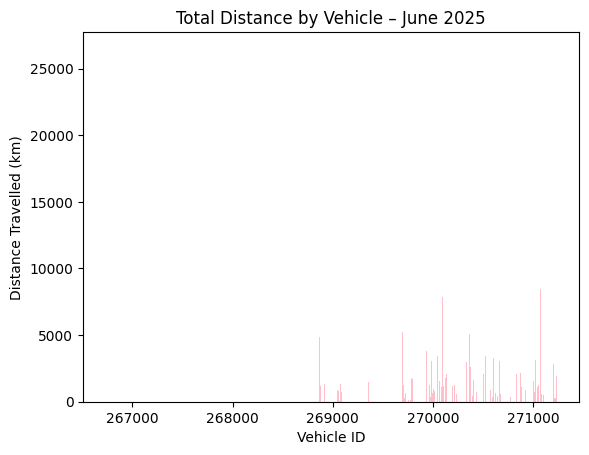

In [71]:
latest_month = vehicle_data['Date'].max()
latest_data = vehicle_data[vehicle_data['Date'] == latest_month]

distance_bar = latest_data.groupby('VehicleId')['Distance'].sum().reset_index()

#plt.bar(distance_bar['VehicleId'].astype(str), distance_bar['Distance'], color='pink')
plt.bar(distance_bar['VehicleId'], distance_bar['Distance'], color='pink')

plt.title(f'Total Distance by Vehicle – {latest_month.strftime("%B %Y")}')
plt.xlabel('Vehicle ID')
plt.ylabel('Distance Travelled (km)')
plt.show()

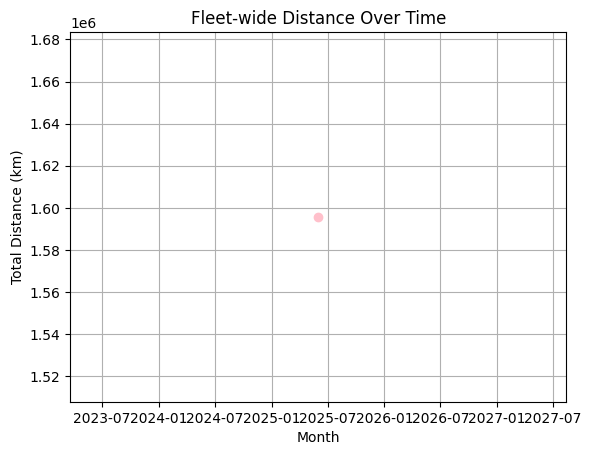

In [75]:
plt.plot(monthly_summary['Date'], monthly_summary['Distance'], marker='o', color='pink')
plt.title('Fleet-wide Distance Over Time')
plt.xlabel('Month')
plt.ylabel('Total Distance (km)')
plt.grid(True)
plt.show()


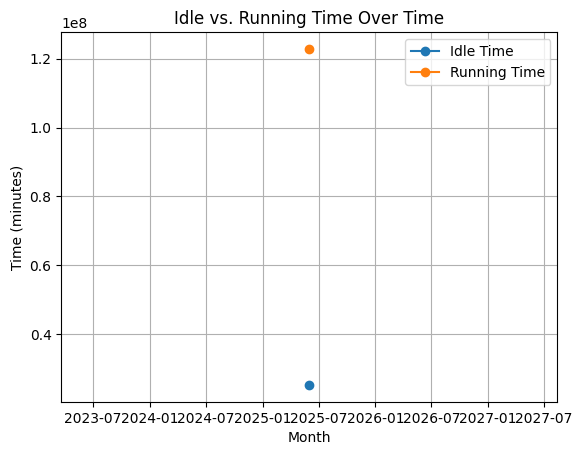

In [79]:
time_monthly = vehicle_data.groupby('Date')[['IdleTime', 'RunningTime']].sum().reset_index()

plt.plot(time_monthly['Date'], time_monthly['IdleTime'], label='Idle Time', marker='o')
plt.plot(time_monthly['Date'], time_monthly['RunningTime'], label='Running Time', marker='o')
plt.title('Idle vs. Running Time Over Time')
plt.xlabel('Month')
plt.ylabel('Time (minutes)')
plt.legend()
plt.grid(True)
plt.show()


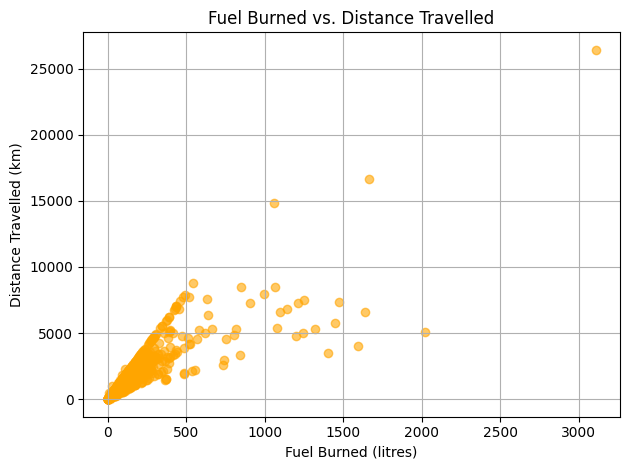

In [81]:
plt.scatter(vehicle_data['FuelBurned'], vehicle_data['Distance'], alpha=0.6, color='orange')
plt.title('Fuel Burned vs. Distance Travelled')
plt.xlabel('Fuel Burned (litres)')
plt.ylabel('Distance Travelled (km)')
plt.grid(True)
plt.tight_layout()
plt.show()


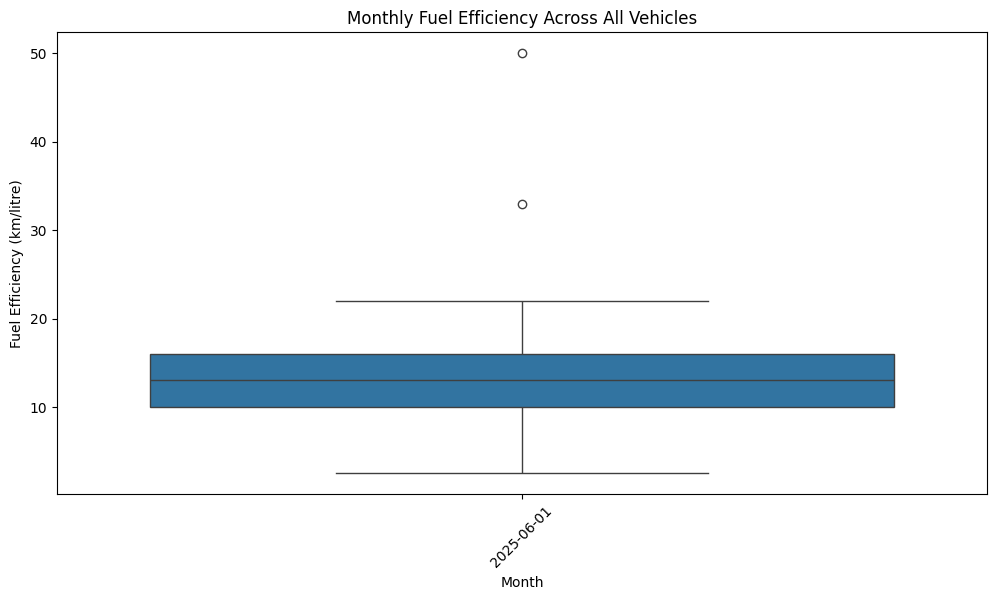

In [83]:
import seaborn as sns

vehicle_data['FuelEfficiency'] = vehicle_data['Distance'] / vehicle_data['FuelBurned']
monthly_eff = vehicle_data[vehicle_data['FuelBurned'] > 0].groupby(['Date', 'VehicleId'])['FuelEfficiency'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Date', y='FuelEfficiency', data=monthly_eff)
plt.title('Monthly Fuel Efficiency Across All Vehicles')
plt.xlabel('Month')
plt.ylabel('Fuel Efficiency (km/litre)')
plt.xticks(rotation=45)
plt.show()
